In [163]:
import os
import pandas as pd
import numpy as np

import dask
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

from tqdm import tqdm
import matplotlib.pyplot as plt

<h3>Read raw files</h3>

In [164]:
raw_path = '../data/sas/raw/data.csv'

In [165]:
raw_data = dd.read_csv(
    raw_path,
    sep=';',  
    encoding='cp1251',
    low_memory=False, 
    dtype={
        'ГородМагазина': 'object',
        'МагазинЗаказа': 'object',
        'СуммаДоставки': 'object',
        'СуммаУслуг'   : 'object',
        'ПВЗ_код'      : 'object',
        'ПричинаОтмены': 'object'
    }
)

In [166]:
with ProgressBar():
    data = raw_data.compute()

[########################################] | 100% Completed | 4.50 ss


In [167]:
data.shape

(730558, 38)

In [168]:
data.columns

Index(['Дата', 'ДатаДоставки', 'НомерЗаказаНаСайте', 'НовыйСтатус',
       'СуммаЗаказаНаСайте', 'СуммаДокумента', 'МетодДоставки', 'ФормаОплаты',
       'Регион', 'Группа2', 'Группа3', 'Группа4', 'Тип', 'Номенклатура',
       'ТипТовара', 'Отменено', 'ПричинаОтмены', 'Количество', 'Цена',
       'СуммаСтроки', 'ЦенаЗакупки', 'МесяцДатыЗаказа', 'ГодДатыЗаказа',
       'ПВЗ_код', 'Статус', 'Гео', 'Маржа', 'СуммаУслуг', 'СуммаДоставки',
       'НомерСтроки', 'КоличествоПроданоКлиенту', 'ДатаЗаказаНаСайте',
       'Телефон_new', 'ЭлектроннаяПочта_new', 'Клиент', 'ID_SKU',
       'ГородМагазина', 'МагазинЗаказа'],
      dtype='object')

<h3>Clean</h3>

In [169]:
numeric = ['СуммаЗаказаНаСайте', 
           'СуммаДокумента', 
           'Количество', 
           'Цена',
           'СуммаСтроки', 
           'ЦенаЗакупки',
           'Маржа', 
           'СуммаУслуг',
           'СуммаДоставки', 
           'КоличествоПроданоКлиенту']

def clear_to_float(x):
    return float(str(x).replace(' ', '').replace(',','.'))

for column in numeric:
    data[column] = data[column].apply(clear_to_float)

<h3>Filter data</h3>

<h4>Filter Phone number</h4>

In [170]:
assert data['Телефон_new'].isna().sum() == 0

In [171]:
# data with valid user phone number
ph_data = data[data['Телефон_new'].str.contains('[0-9]{8}-[0-9]{14}')] # phone data`

In [172]:
ph_data.shape

(727727, 38)

In [173]:
################################################################################

<h4>Filter region</h4>

In [180]:
TOP_N_REGIONS = 37

regions = ph_data['Регион'].value_counts(normalize=True).round(2)[:TOP_N_REGIONS]
regions

Москва                                        0.45
Санкт-Петербург                               0.06
Нижний Новгород                               0.03
Самара                                        0.02
Екатеринбург                                  0.02
Люберцы (Люберецкий район)                    0.01
Воронеж                                       0.01
Ростов-на-Дону                                0.01
Челябинск                                     0.01
Пермь                                         0.01
Краснодар                                     0.01
Тула                                          0.01
Подольск (Московская область район)           0.01
Саратов                                       0.01
Казань                                        0.01
Мытищи (Мытищинский район)                    0.01
Благовещенск                                  0.01
Новосибирск                                   0.01
Балашиха (Балашихинский район)                0.01
Рязань                         

In [181]:
region_data = ph_data[ph_data['Регион'].isin(regions.index)]

<h4>Filter price</h4>

In [182]:
region_data[['Цена', 'СуммаЗаказаНаСайте', 'Количество']].describe().round(2)

,Цена,СуммаЗаказаНаСайте,Количество
count,595048.00,595048.00,595048.00
mean,670.15,4439.38,1.44
std,1825.37,5426.95,1.98
min,0.00,1.00,0.00
25%,89.00,1653.00,1.00
50%,219.00,2929.00,1.00
75%,629.30,5213.00,1.00
max,74990.00,150063.00,150.00


In [189]:
# filter by quantity
pf_data = region_data[region_data['Количество'] != 0]
# filter by price
threshold = pf_data['Цена'].quantile(0.025)
pf_data = pf_data[pf_data['Цена'] > threshold]
print('Remove every order with price lower than', threshold)

Remove every order with price lower than 22.0


<h4>Filter date</h4>

In [190]:
pf_data['Дата'] = pd.to_datetime(pf_data['Дата'], dayfirst=True)
pf_data['ДатаДоставки'] = pd.to_datetime(pf_data['ДатаДоставки'], dayfirst=True)

In [191]:
print(pf_data['Дата'].min().date().strftime('%d/%m/%Y'), '->', pf_data['Дата'].max().date().strftime('%d/%m/%Y'))

01/05/2017 -> 30/06/2017


In [192]:
print(pf_data['ДатаДоставки'].min().date().strftime('%d/%m/%Y'), '->', pf_data['ДатаДоставки'].max().date().strftime('%d/%m/%Y'))

19/04/2017 -> 08/08/2018


In [193]:
pf_data.groupby(pd.Grouper(key='ДатаДоставки', freq='M'))['Дата'].count()

ДатаДоставки
2017-04-30         3
2017-05-31    232894
2017-06-30    273675
2017-07-31     56421
2017-08-31       271
2017-09-30         0
2017-10-31         0
2017-11-30         0
2017-12-31         0
2018-01-31         0
2018-02-28         0
2018-03-31         0
2018-04-30         0
2018-05-31         0
2018-06-30         0
2018-07-31         0
2018-08-31         7
Freq: M, Name: Дата, dtype: int64

In [195]:
# time filtered data
tf_data = pf_data[pf_data['ДатаДоставки'] > pd.Timestamp(year=2017, month=5, day=1)]
tf_data = pf_data[pf_data['ДатаДоставки'] < pd.Timestamp(year=2017, month=9, day=1)]

<h3>Item parameters</h3>

In [196]:
tf_data['Группа2'].value_counts().head(4)

ТЕКСТИЛЬ, ТРИКОТАЖ    99163
ДЕТСКОЕ ПИТАНИЕ       96232
ИГРУШКИ               93262
ПОДГУЗНИКИ            47694
Name: Группа2, dtype: int64

In [197]:
tf_data['Группа3'].value_counts().head(4)

ПЮРЕ                                  53489
ПОДГУЗНИКИ                            43279
ОДЕЖДА ДЛЯ НОВОРОЖДЕННЫХ (0-2 лет)    32446
ИГРУШКИ ДЛЯ РАЗВИТИЯ МАЛЫШЕЙ          30936
Name: Группа3, dtype: int64

In [198]:
tf_data['Группа4'].value_counts().head(4)

трусики-подгузники    21177
подгузники            19490
пюре фруктовые        18271
пюре мясные           16148
Name: Группа4, dtype: int64

In [199]:
tf_data['Тип'].value_counts()

ППКП       219875
ОДЕЖДА     123039
ИГРУШКИ    108005
ИНОЕ        85699
КГТ         26646
Name: Тип, dtype: int64

In [200]:
tf_data['ТипТовара'].value_counts()

МГТ    456790
КГТ     26587
Name: ТипТовара, dtype: int64

In [201]:
(tf_data['ID_SKU'].value_counts() > 50).sum()

1308

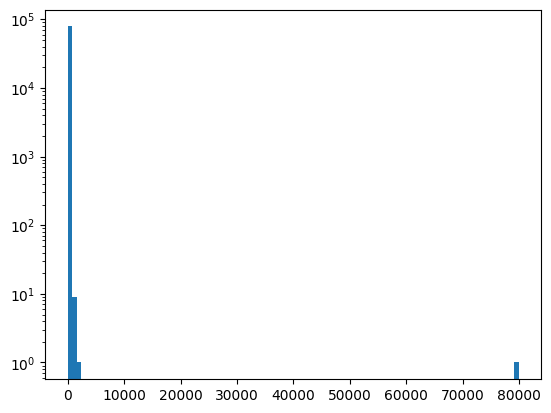

In [202]:
plt.hist(tf_data['ID_SKU'].value_counts(), bins=100, log=True);

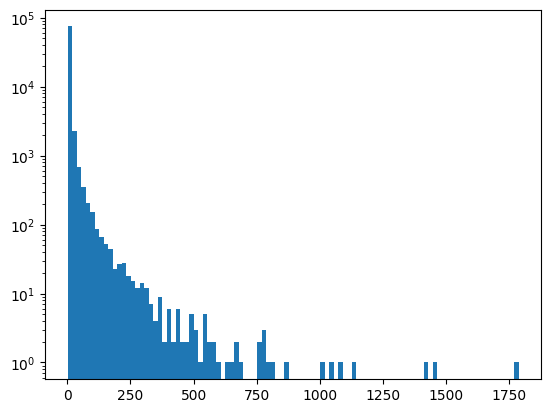

In [203]:
plt.hist(tf_data['ID_SKU'].value_counts()[1:], bins=100, log=True);

In [204]:
tf_data['ID_SKU'].value_counts()[0:2]

ID10022107250    79887
ID10001195351     1787
Name: ID_SKU, dtype: int64

In [205]:
data['ID_SKU'].value_counts()[0:2]

ID10022107250    99524
ID10001195351     2140
Name: ID_SKU, dtype: int64

In [206]:
data[data['ID_SKU'] == 'ID10022107250'].iloc[10]

Дата                                01.05.2017 3:21
ДатаДоставки                        08.05.2017 0:00
НомерЗаказаНаСайте                       4513822_TR
НовыйСтатус                          Возврат из ПВЗ
СуммаЗаказаНаСайте                            437.0
СуммаДокумента                                437.0
МетодДоставки                              Магазины
ФормаОплаты                             Безналичная
Регион                                       Москва
Группа2                                         NaN
Группа3                                         NaN
Группа4                                         NaN
Тип                                            ИНОЕ
Номенклатура                               Доставка
ТипТовара                                       NaN
Отменено                                        Нет
ПричинаОтмены                                   NaN
Количество                                      1.0
Цена                                           49.0
СуммаСтроки 

In [207]:
tf_data[tf_data['ID_SKU'] != 'ID10022107250'].shape

(483377, 38)

In [208]:
tf_data = tf_data[tf_data['ID_SKU'] != 'ID10022107250']

<h3>DataFrame</h3>

In [209]:
from pathlib import Path

In [210]:
Path("../data/sas/").mkdir(parents=True, exist_ok=True)

In [211]:
df = tf_data[['Дата', 'ID_SKU', 'Телефон_new', 'Цена', 'Количество', 'Группа2', 'Группа3', 'Группа4', 'Тип', 'ТипТовара']]

In [212]:
df.to_csv('../data/sas/positions.csv', index=False)

In [213]:
################################################################################

In [214]:
tf_data.to_csv('../data/sas/all_positions.csv', index=False)